# Assignment 4 GDAA2030 Image Analytics
### By: Tato' Crisanto
### For: James Rapaport

The purpose of this assignment is to analyse crop yield using the NDVI vegetation index. This will be for the years 2013-2023 for the province of Prince Edward Island.

In [1]:
import os
from zipfile import ZipFile
import rasterio
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.features import rasterize, Affine
from rasterio.warp import calculate_default_transform, reproject 
import shapely
from shapely.geometry import shape, mapping, box
from shapely.ops import transform
import json
import numpy as np
import glob
from scipy.integrate import trapz
import sqlite3
import matplotlib.pyplot as plt
from scipy.stats import linregress

### Task 1:
Create a raster dataset for each of the years 2013-2023 that records the proportion of each pixel that is cropped with potatoes. This chunk retreives the coordinate reference system from eVIIRS.

In [2]:
# Define directories
aci_dir = 'C:/geospatial2030gdaa/Assignment4TC/annual-crop-inventory/'
eviirs_path = 'C:/geospatial2030gdaa/Assignment4TC/eviirs-ndvi-20231203.zip'
out_dirs = 'C:/geospatial2030gdaa/Assignment4TC/output-aci/'
years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

# Retrive eVIIRS crs to use for ACI crs conversion for the given years
with rasterio.open(f'zip://{eviirs_path}!/GN_eVSH_NDVI.2013.121-130.1KM.VI_NDVI.001.2023098064738.tif') as eviirs:
    eviirs_crs = eviirs.crs
    
os.makedirs(out_dirs, exist_ok=True)

for y in years:
    aci_zip = os.path.join(aci_dir, f'aci_{y}_pe.zip')
    out_path = os.path.join(out_dirs,f'output_aci{y}_pe.tif')
    
    with rasterio.open(f'zip://{aci_zip}!/aci_{y}_pe.tif') as aci:
        transform, width, height = calculate_default_transform(
            aci.crs,
            eviirs_crs,
            aci.width,
            aci.height,
            *aci.bounds
        )
        profile = aci.meta.copy()
        profile.update({
            'crs': eviirs_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
        
        with rasterio.open(out_path, 'w', **profile) as output:
            for i in range(1, aci.count +1):
                reproject(
                    source=rasterio.band(aci, i),
                    destination=rasterio.band(output, i),
                    src_transform=aci.transform,
                    src_crs=aci.crs,
                    dst_transform=transform,
                    dst_crs=eviirs_crs,
                    resampling=Resampling.nearest
                )
                
# Check to make sure the crs are correct
print(eviirs.crs)
print(output.crs)

EPSG:4326
EPSG:4326


This chunk retrieved the bounding box of eVIIRS.

In [3]:
# Define new cropped directory
crop_dir = 'C:/geospatial2030gdaa/Assignment4TC/crop_aci/'

os.makedirs(crop_dir, exist_ok=True)

# Retrieve bounding box for eVIIRS
with rasterio.open(f'zip://{eviirs_path}!/GN_eVSH_NDVI.2013.121-130.1KM.VI_NDVI.001.2023098064738.tif') as eviirs:
    bbox = box(*eviirs.bounds)
    bbox_geojson = json.loads(json.dumps(bbox.__geo_interface__))
    
# Loop through reprojected aci datasets for cropping
for y in years:
    in_path = os.path.join(out_dirs, f'output_aci{y}_pe.tif')
    out_path = os.path.join(crop_dir, f'crop_aci{y}_pe.tif')
    
    with rasterio.open(in_path) as source:
        out_image, out_transform = mask(source, [bbox_geojson], crop=True)
        out_profile = source.meta.copy()
        out_profile.update({'driver': "GTiff",
                            'height': out_image.shape[1],
                            'width': out_image.shape[2],
                            'transform': out_transform
        })
        
        with rasterio.open(out_path, 'w', **out_profile) as out:
            out.write(out_image)

This chunk loops through to apply the mask the ACI as well as calculates the proportion of the cropped potatoes for the given years.

In [4]:
# Define potato proportion directory
potato_dir = 'C:/geospatial2030gdaa/Assignment4TC/potato_proportions'

os.makedirs(potato_dir, exist_ok=True)

with rasterio.open(f'zip://{eviirs_path}!/GN_eVSH_NDVI.2013.121-130.1KM.VI_NDVI.001.2023098064738.tif') as eviirs:
    eviirs_transform = eviirs.transform
    eviirs_height = eviirs.height 
    eviirs_width = eviirs.width   
    
    # Loop through cropped dataset to calculate potato proportion
    for year in years:
        in_path = os.path.join(crop_dir, f'crop_aci{year}_pe.tif')
        
        with rasterio.open(in_path, 'r') as aci:
            potato_prop = np.zeros((eviirs_height, eviirs_width), dtype=np.float32)
            for row in range(eviirs_height):
                for col in range(eviirs_width):
                    x, y = eviirs_transform *(col, row)
                    pxl_geom = box(x, y, x + eviirs_transform.a, y + eviirs_transform.e)
                    geosjon_geom = mapping(pxl_geom)
                    
                    # Test the geometry to mask the aci
                    try:
                        out_image, out_transform = mask(aci, [geosjon_geom], crop=True)
                        potato_pixel = np.count_nonzero(out_image == 177)
                        all_pixel = out_image.size
                        
                        if all_pixel > 0:
                            potato_prop[row, col] = (potato_pixel / all_pixel) * 100
                        else:
                            potato_prop[row, col] = 0
                    except ValueError:
                        potato_prop[row, col] = np.nan
                        
            # Output new tif
            out_path = os.path.join(potato_dir, f'potato{year}_pe.tif')
            
            with rasterio.open(out_path, 'w',
                               driver='GTiff',
                               width=eviirs_width,
                               height=eviirs_height,
                               count=1,
                               dtype='float32',
                               crs=eviirs.crs,
                               transform=eviirs_transform) as potato:
                potato.write(potato_prop, 1)
    

### Task 2:
To produce a linear regression model plotting time-integrated NDVI against known potato yield. This chunk calculates the integrated NDVI values and the average yield for the given years.

In [5]:
# Set threshold
threshold = 77
eviirs_dir = 'C:/geospatial2030gdaa/Assignment4TC/eviirs-ndvi-20231203'


# Initiate lists for NDVI and yield value storage
integrate_ndvi_val = []
ave_yield_val = []

# Define function to fin eVIIRS value for given year
def eviirs_file(year):
    pattern = f'GN_eVSH_NDVI.{year}*.tif'
    file_path = glob.glob(os.path.join(eviirs_dir, pattern))
    file_path = [path for path in file_path if 'QUAL' not in os.path.basename(path)]
    return file_path

# Define function to calculate integrated NDVI profiles for given years
def calc_int_NDVI(crop_file, year, threshold):
    integrate_ndvi_profile = []
    day_num = []
    
    #Find the eVIIRS files fro the given year
    file_path = eviirs_file(year)
    for file in file_path:
        day_num.append(int(file.split('.')[2][4:7]))
        try:
            with rasterio.open(file) as eviirs_ndvi:
                with rasterio.open(crop_file, 'r') as crop_prop:
                    ndvi_data = eviirs_ndvi.read(1)
                    crop_prop_mask = crop_prop.read(1) >= threshold
                    ndvi_data = ndvi_data * crop_prop_mask
                    mean_ndvi = np.mean(ndvi_data[ndvi_data != 0]) / 10000  
                    integrate_ndvi_profile.append(mean_ndvi)
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
            
    # Use trapz to integrate NDVI
    integrate_ndvi = trapz(integrate_ndvi_profile, day_num)
    integrate_ndvi_val.append(integrate_ndvi)
    # print(year, integrate_ndvi)
    return integrate_ndvi

# Connect to SQL database
connect = sqlite3.connect(r'C:\geospatial2030gdaa\Assignment4TC\statistics-canada.db')
cursor = connect.cursor()

# Loop through the years
for year in years:
    proportion_path = os.path.join(potato_dir, f'potato{year}_pe.tif')
    integrate_ndvi = calc_int_NDVI(proportion_path, year, threshold)
    
    # Get yeild data
    cursor.execute("""
                   select year, name, average_yield
        from potato_production 
        where year = ? and name = 'Prince Edward Island'
        order by year
    """, (year,))
    
    result = cursor.fetchone()
    if result:
        year, name, average_yield = result
        # print(f"Year: {year}, Average Yield: {average_yield}")
        ave_yield_val.append(average_yield)
    else:
        print(f"No data for year {year}.")
        
# Close connection
connect.close()

# Convert to numpy arrays
integrate_ndvi_array = np.array(integrate_ndvi_val)
ave_yield_array = np.array(ave_yield_val)

C:\Users\tatoc\AppData\Local\Temp\ipykernel_29972\4103297398.py:38: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  integrate_ndvi = trapz(integrate_ndvi_profile, day_num)


This chunk plots the results.

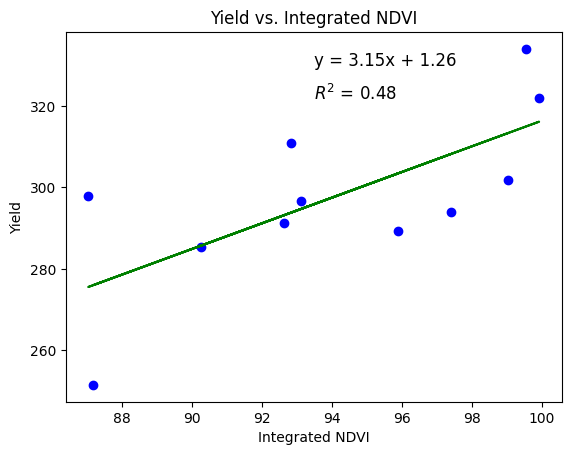

In [6]:
# Plot Yield and Integrated NDVI
ndvi = np.array(integrate_ndvi_array)
potato_yield = np.array(ave_yield_array)

# Make sure inputs are not empty and have more than one element
if ndvi.size > 1 and potato_yield.size > 1:
    slope, intercept, r_value, p_value, std_err = linregress(ndvi, potato_yield)
    
    # Define predict function
    def predict(x):
        return slope * x + intercept
    
    # Generate line:
    fit_line = predict(ndvi)
    
    # Plot
    plt.scatter(ndvi, potato_yield, color='blue')
    plt.plot(ndvi, fit_line, color='green')
    plt.xlabel('Integrated NDVI')
    plt.ylabel('Yield')
    plt.title('Yield vs. Integrated NDVI')
    plt.text(max(ndvi) - 0.5*(max(ndvi) - min(ndvi)), max(potato_yield) - 0.05*(max(potato_yield) - min(potato_yield)), f'y = {slope:.2f}x + {intercept:.2f}', fontsize=12)
    plt.text(max(ndvi) - 0.5*(max(ndvi) - min(ndvi)), max(potato_yield) - 0.15*(max(potato_yield) - min(potato_yield)), f'$R^2$ = {r_value**2:.2f}', fontsize=12)
else:
    print("Error: Not enough data for analysis.")


I used a 77% threshold since 80 was too high and one of my years was unable to have at least 80% therefore my NDVI values were all zeros. 